In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
import numpy as np
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('DataTokopedia.csv')
df.head()

,Ulasan
0,Tidak sesuai
1,kancing nya agak keras
2,Enak nyaman dipakainya
3,"suka bagian leher nya, ngepress"
4,ukurannya ga sesuai nih gais. kalian yg mau be...


In [3]:
df_copy = df.copy()

# Pre-Processing Data

### A. Case Folding

In [4]:
def casefolding(Review):
    Review = Review.lower()
    return Review

df_copy['Ulasan'] = df_copy['Ulasan'].apply(casefolding)

In [5]:
df_copy.head()

,Ulasan
0,tidak sesuai
1,kancing nya agak keras
2,enak nyaman dipakainya
3,"suka bagian leher nya, ngepress"
4,ukurannya ga sesuai nih gais. kalian yg mau be...


### B. Remove  Punctuation

In [6]:
def removePunctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

df_copy['Ulasan'] = df_copy['Ulasan'].apply(removePunctuation)

In [7]:
df_copy.head()

,Ulasan
0,tidak sesuai
1,kancing nya agak keras
2,enak nyaman dipakainya
3,suka bagian leher nya ngepress
4,ukurannya ga sesuai nih gais kalian yg mau bel...


### C. Word Normalizer

In [8]:
kamus_df = pd.read_excel("kamus perbaikan kata.xlsx")

norm_dict = dict(zip(kamus_df['TIDAK BAKU'].astype(str).str.strip(), kamus_df['BAKU'].astype(str).str.strip()))

In [9]:
def normalisasi(text):
    for pattern, replacement in norm_dict.items():
        escaped_pattern = re.escape(pattern)
        regex_pattern = r'\b' + escaped_pattern + r'\b'
        text = re.sub(regex_pattern, replacement, text)
    return text

df_copy['Ulasan'] = df_copy['Ulasan'].apply(normalisasi)

In [10]:
df_copy.head()

,Ulasan
0,tidak sesuai
1,kancing nya agak keras
2,enak nyaman dipakainya
3,suka bagian leher nya ngepress
4,ukuranya tidak sesuai ini gais kalian yang mau...


### D. Stopword Removal

In [11]:
factory = StopWordRemoverFactory()
stop_word_list = factory.get_stop_words()

stop_word_list = [word for word in stop_word_list if word != 'tidak']

new_array = ArrayDictionary(stop_word_list)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

df_copy['Ulasan'] = df_copy['Ulasan'].apply(lambda x: stopword(x))
df_copy.head()

,Ulasan
0,tidak sesuai
1,kancing nya keras
2,enak nyaman dipakainya
3,suka bagian leher nya ngepress
4,ukuranya tidak sesuai gais kalian mau beli uku...


### E. Tokenizing

In [12]:
tokenized = df_copy['Ulasan'].apply(lambda x:x.split())
tokenized

0                                         [tidak, sesuai]
1                                   [kancing, nya, keras]
2                              [enak, nyaman, dipakainya]
3                    [suka, bagian, leher, nya, ngepress]
4       [ukuranya, tidak, sesuai, gais, kalian, mau, b...
                              ...                        
4020        [ukuranya, kecil, banget, kayanya, under, 38]
4021    [repeat, order, cocok, ukuranya, suka, modelny...
4022                  [bahannya, enak, cuttingannya, oke]
4023    [ukuranya, pas, tinggi, badan, 171, 180, cuma,...
4024       [ukuranya, pas, tinggi, badan, 160, 170, cuma]
Name: Ulasan, Length: 4025, dtype: object

### F. Stemming

In [ ]:
def stemming(Ulasan):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in Ulasan :
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean = []  
    d_clean = " ".join(do)
    return d_clean
tokenized = tokenized.apply(stemming)

In [14]:
tokenized.to_csv('DataPreprocessing.csv', index=False)

In [15]:
data_clean = pd.read_csv('DataPreprocessing.csv', encoding='latin1')
data_clean.head()

,Ulasan
0,tidak sesuai
1,kancing nya keras
2,enak nyaman pakai
3,suka bagi leher nya ngepress
4,ukuranya tidak sesuai gais kalian mau beli uku...


# Labeling Otomatis

In [ ]:
import pandas as pd
from sentistrength_id import sentistrength

# Konfigurasi
config = {
    "negation": True,
    "booster": True,
    "ungkapan": True,
    "consecutive": True,
    "repeated": True,
    "emoticon": True,
    "question": True,
    "exclamation": True,
    "punctuation": True
}

ss = sentistrength(config)

df = pd.read_csv("DataPreprocessing.csv")

def label_sentimen_safe(x):
    try:
        hasil = ss.main(str(x))
        if isinstance(hasil, dict) and "kelas" in hasil:
            return hasil["kelas"]
        else:
            return "tidak terdeteksi"
    except Exception as e:
        print(f"Error saat memproses: {x} => {e}")
        return "error"

df["label_sentimen"] = df["Ulasan"].apply(label_sentimen_safe)

df.to_csv("ulasan_berlabel.csv", index=False)
print("Berhasil menyimpan file 'ulasan_berlabel.csv' dengan label sentimen.")

{'classified_text': 'agnezmo pintar [4] dan cantik [6] sekali tetapi lintah darat [-4] :) [3]', 'tweet_text': ' agnezmo pintar dan cantik sekali tetapi lintah darat :)', 'sentence_score': ['agnezmo pintar [4] dan cantik [6] sekali tetapi lintah darat [-4] :) [3]'], 'max_positive': 6, 'max_negative': -4, 'kelas': 'positive'}
Berhasil menyimpan file 'ulasan_berlabel.csv' dengan label sentimen.


In [17]:
df = pd.read_csv("ulasan_berlabel.csv")

In [18]:
df.head()

,Ulasan,label_sentimen
0,tidak sesuai,negative
1,kancing nya keras,negative
2,enak nyaman pakai,positive
3,suka bagi leher nya ngepress,positive
4,ukuranya tidak sesuai gais kalian mau beli uku...,neutral


In [19]:
df.isnull().sum()

Ulasan            5
label_sentimen    0
dtype: int64

In [20]:
df[df['Ulasan'].isna()]

,Ulasan,label_sentimen
133,NaN,neutral
219,NaN,neutral
1757,NaN,neutral
2125,NaN,neutral
2940,NaN,neutral


In [21]:
df['Ulasan'] = df['Ulasan'].fillna("tidak ada komentar")

In [22]:
df.isnull().sum()

Ulasan            0
label_sentimen    0
dtype: int64

In [23]:
df.to_csv('DataTokopediaBersih.csv', index=False)

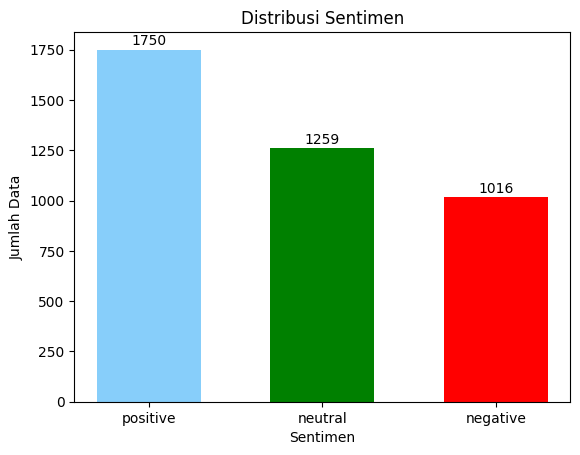

In [ ]:
import matplotlib.pyplot as plt

label_counts = df['label_sentimen'].value_counts()

labels = label_counts.index.tolist()
values = label_counts.values.tolist()

color_map = {
    'negative': 'red',
    'neutral': 'green',
    'positive': 'lightskyblue'
}
colors = [color_map[label] for label in labels]

plt.bar(labels, values, width=0.6, color=colors)
plt.title('Distribusi Sentimen')
plt.ylabel('Jumlah Data')
plt.xlabel('Sentimen')

for i, value in enumerate(values):
    plt.text(i, value + 10, str(value), ha='center', va='bottom', fontsize=10)

plt.show()


# Menghitung Data Menggunakan TF-IDF

In [25]:
Ulasan = df['Ulasan']

In [26]:
cv = CountVectorizer()
term_fit = cv.fit(Ulasan)

In [27]:
dokumen = term_fit.transform(Ulasan)

In [28]:
tfidf_transformer = TfidfTransformer().fit(dokumen)
idf_value = tfidf_transformer.idf_
words = term_fit.get_feature_names_out()

In [29]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(dokumen)

In [30]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=words)

In [31]:
df_tfidf_mean = df_tfidf.mean(axis=0).reset_index()
df_tfidf_mean.columns = ['Kata', 'TF-IDF']

In [32]:
df_tfidf_mean.to_csv('tfidf_value.csv', index=False)

In [33]:
print(df_tfidf_mean)

           Kata    TF-IDF
0            05  0.000064
1          0800  0.000037
2            10  0.000685
3           100  0.000590
4         100cm  0.000172
...         ...       ...
3031       your  0.000054
3032    yuniklo  0.000090
3033     zipper  0.000891
3034  zippernya  0.000142
3035      zonkk  0.000114

[3036 rows x 2 columns]


# Pengujian Split

In [34]:
X = df['Ulasan']
y = df['label_sentimen']

Testing

In [35]:
splits = [
    {"train": 0.6, "val": 0.2, "test": 0.2},
    {"train": 0.7, "val": 0.15, "test": 0.15},
    {"train": 0.8, "val": 0.1, "test": 0.1},
    {"train": 0.5, "val": 0.25, "test": 0.25},
    {"train": 0.75, "val": 0.15, "test": 0.1},
    {"train": 0.85, "val": 0.1, "test": 0.05},
    {"train": 0.7, "val": 0.1, "test": 0.2},
    {"train": 0.65, "val": 0.2, "test": 0.15}
    ]

In [36]:
results_nb = []

In [37]:
for split in splits:
    # Tahap 1: split train + temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-split["train"], stratify=y, random_state=42)

    # Tahap 2: split val + test dari temp
    val_size = split["val"] / (split["val"] + split["test"])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-val_size, stratify=y_temp, random_state=42)

    # TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)

    # Model Naive Bayes
    model = ComplementNB()
    model.fit(X_train_vec, y_train)

    # Evaluasi
    val_acc = accuracy_score(y_val, model.predict(X_val_vec))
    test_acc = accuracy_score(y_test, model.predict(X_test_vec))

    results_nb.append({
        "split": f"{int(split['train']*100)}-{int(split['val']*100)}-{int(split['test']*100)}",
        "val_accuracy_nb": round(val_acc, 4),
        "test_accuracy_nb": round(test_acc, 4)
    })
    
result_df_nb = pd.DataFrame(results_nb)
print(result_df_nb)

      split  val_accuracy_nb  test_accuracy_nb
0  60-20-20           0.7193            0.7416
1  70-15-15           0.7649            0.7334
2  80-10-10           0.7662            0.7171
3  50-25-25           0.7147            0.7339
4  75-15-10           0.7467            0.7320
5   85-10-5           0.7537            0.7079
6  70-10-20           0.7711            0.7382
7  65-20-15           0.7453            0.7318


In [38]:
results_svm = []

In [ ]:
for split in splits:

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=1 - split["train"], stratify=y, random_state=42
    )

    val_size = split["val"] / (split["val"] + split["test"])
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1 - val_size, stratify=y_temp, random_state=42
    )

    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)

    # Model Linear SVM
    model = LinearSVC()
    model.fit(X_train_vec, y_train)

    val_acc = accuracy_score(y_val, model.predict(X_val_vec))
    test_acc = accuracy_score(y_test, model.predict(X_test_vec))

    results_svm.append({
        "split": f"{int(split['train']*100)}-{int(split['val']*100)}-{int(split['test']*100)}",
        "val_accuracy_svm": round(val_acc, 4),
        "test_accuracy_svm": round(test_acc, 4)
    })

result_df_svm = pd.DataFrame(results_svm)
print(result_df_svm)

      split  val_accuracy_svm  test_accuracy_svm
0  60-20-20            0.8050             0.8174
1  70-15-15            0.8212             0.8013
2  80-10-10            0.8035             0.8213
3  50-25-25            0.8032             0.8113
4  75-15-10            0.8278             0.8065
5   85-10-5            0.8234             0.7772
6  70-10-20            0.8109             0.8114
7  65-20-15            0.8075             0.8262


# Split Data (Training, Validation, Testing)

In [40]:
# 70% train, 30% sisanya (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Dari sisa 30%, ambil 1/3 untuk validasi (10%) dan 2/3 untuk test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), stratify=y_temp, random_state=42)


In [41]:
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data validation: {len(X_val)}")
print(f"Jumlah data testing: {len(X_test)}")

Jumlah data training: 2817
Jumlah data validation: 402
Jumlah data testing: 806


In [42]:
vectorizer = TfidfVectorizer(decode_error='replace', encoding='utf-8')

In [ ]:
X_train_tfidf = vectorizer.fit_transform(X_train)

X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Naive Bayes

In [44]:
nb_model = ComplementNB()
start_time_nb = time.time()
nb_model.fit(X_train_tfidf, y_train)
end_time_nb = time.time()
training_time_nb = end_time_nb - start_time_nb

In [ ]:
y_val_pred = nb_model.predict(X_val_tfidf)

In [46]:
val_accuracy_nb = accuracy_score(y_val, y_val_pred)
val_class_report_nb = classification_report(y_val, y_val_pred)
val_conf_matrix_nb = confusion_matrix(y_val, y_val_pred)

In [47]:
y_test_pred = nb_model.predict(X_test_tfidf)

In [48]:
test_accuracy_nb = accuracy_score(y_test, y_test_pred)
test_class_report_nb = classification_report(y_test, y_test_pred)
test_conf_matrix_nb = confusion_matrix(y_test, y_test_pred)

In [49]:
print(f"Naive Bayes Training Time: {training_time_nb:.4f} seconds\n")
print(f"Validation Classification Report (Naive Bayes):\n{val_class_report_nb}")
print(f"======================================\n")
print(f"Testing Classification Report (Naive Bayes):\n{test_class_report_nb}")

Naive Bayes Training Time: 0.0192 seconds

Validation Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    negative       0.64      0.80      0.71       101
     neutral       0.81      0.58      0.68       126
    positive       0.84      0.89      0.86       175

    accuracy                           0.77       402
   macro avg       0.76      0.76      0.75       402
weighted avg       0.78      0.77      0.77       402


Testing Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    negative       0.59      0.80      0.68       204
     neutral       0.77      0.60      0.67       252
    positive       0.84      0.80      0.82       350

    accuracy                           0.74       806
   macro avg       0.73      0.73      0.72       806
weighted avg       0.76      0.74      0.74       806



In [50]:
print(f"Akurasi Validation Naive Bayes: {val_accuracy_nb:.4f}")
print(f"Akurasi Testing Naive Bayes: {test_accuracy_nb:.4f}")

Akurasi Validation Naive Bayes: 0.7711
Akurasi Testing Naive Bayes: 0.7382


In [51]:
print(f"Naive Bayes Training Time: {training_time_nb:.4f} seconds\n")
print(f"Classification Report (Naive Bayes):\n{test_class_report_nb}")

Naive Bayes Training Time: 0.0192 seconds

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    negative       0.59      0.80      0.68       204
     neutral       0.77      0.60      0.67       252
    positive       0.84      0.80      0.82       350

    accuracy                           0.74       806
   macro avg       0.73      0.73      0.72       806
weighted avg       0.76      0.74      0.74       806



# Support Vector Machine

In [52]:
svm_model = LinearSVC()
start_time_svm = time.time()
svm_model.fit(X_train_tfidf, y_train)
end_time_svm = time.time()
training_time_svm = end_time_svm - start_time_svm

In [ ]:
y_val_pred_svm = svm_model.predict(X_val_tfidf)

In [ ]:
val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
val_class_report_svm = classification_report(y_val, y_val_pred_svm)
val_conf_matrix_svm = confusion_matrix(y_val, y_val_pred_svm)

In [ ]:
y_test_pred_svm = svm_model.predict(X_test_tfidf)

In [ ]:
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_class_report_svm = classification_report(y_test, y_test_pred_svm)
test_conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)

In [57]:
print(f"SVM Training Time: {training_time_svm:.4f} seconds\n")
print(f"Validation Classification Report (SVM):\n{val_class_report_svm}")
print(f"======================================\n")
print(f"Testing Classification Report (SVM):\n{test_class_report_svm}")

SVM Training Time: 0.1000 seconds

Validation Classification Report (SVM):
              precision    recall  f1-score   support

    negative       0.74      0.72      0.73       101
     neutral       0.77      0.75      0.76       126
    positive       0.87      0.90      0.89       175

    accuracy                           0.81       402
   macro avg       0.80      0.79      0.79       402
weighted avg       0.81      0.81      0.81       402


Testing Classification Report (SVM):
              precision    recall  f1-score   support

    negative       0.71      0.79      0.75       204
     neutral       0.76      0.79      0.78       252
    positive       0.92      0.83      0.88       350

    accuracy                           0.81       806
   macro avg       0.80      0.81      0.80       806
weighted avg       0.82      0.81      0.81       806



In [58]:
print(f"Akurasi Validation SVM: {val_accuracy_svm:.4f}")
print(f"Akurasi Testing SVM: {test_accuracy_svm:.4f}")

Akurasi Validation SVM: 0.8109
Akurasi Testing SVM: 0.8114


In [59]:
print(f"SVM Training Time: {training_time_svm:.4f} seconds\n")
print(f"Classification Report (SVM):\n{test_class_report_svm}")

SVM Training Time: 0.1000 seconds

Classification Report (SVM):
              precision    recall  f1-score   support

    negative       0.71      0.79      0.75       204
     neutral       0.76      0.79      0.78       252
    positive       0.92      0.83      0.88       350

    accuracy                           0.81       806
   macro avg       0.80      0.81      0.80       806
weighted avg       0.82      0.81      0.81       806



# Perbandingan Akurasi Naive Bayes dan Support Vector Machine

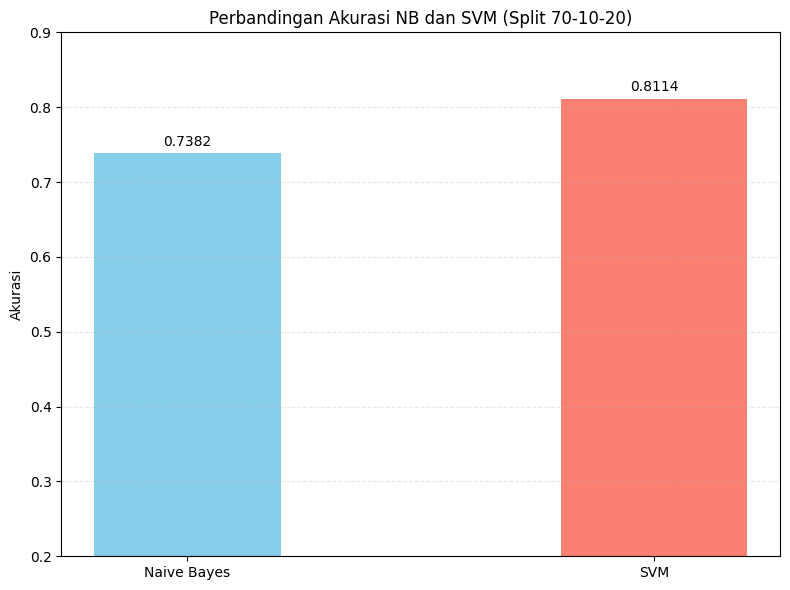

In [ ]:
algorithms = ['Naive Bayes', 'SVM']
test_accuracies = [0.7382, 0.8114]

x = np.arange(len(algorithms))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 6))
bars_nb = ax.bar(x[0], test_accuracies[0], width, label='Naive Bayes', color='skyblue')
bars_svm = ax.bar(x[1], test_accuracies[1], width, label='SVM', color='salmon')

ax.set_ylabel('Akurasi')
ax.set_title('Perbandingan Akurasi NB dan SVM (Split 70-10-20)')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.set_ylim(0.2, 0.9)
ax.bar_label(bars_nb, fmt='%.4f', padding=3)
ax.bar_label(bars_svm, fmt='%.4f', padding=3)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.show()

# Prediksi Sentimen

### Naive Bayes

In [ ]:
def predict_new_sentiment(text):

    original_text = text

    text = casefolding(text)
    text = normalisasi(text)
    text = stopword(text)
    text = stemming(text.split())

    preprocessed_text = text

    text_vec = vectorizer.transform([preprocessed_text])

    prediction = nb_model.predict(text_vec)[0]

    if prediction == 'positive':
        sentiment = 'Positif'
    elif prediction == 'negative':
        sentiment = 'Negatif'
    elif prediction == 'neutral':
        sentiment = 'Netral'
    else:
        sentiment = 'Tidak diketahui'

    return original_text, preprocessed_text, sentiment

In [62]:
print("Prediksi Menggunakan Naive Bayes (3 Kelas)")
new_text = 'ukuranya pas tinggi badan 160 - 170 cm berat badan  60 kg'
original_text, preprocessed_text, predicted_sentiment = predict_new_sentiment(new_text)

print(f"Teks asli: {original_text}")
print(f"Hasil preprocessing: {preprocessed_text}")
print(f"Prediksi sentimen: {predicted_sentiment}")

Prediksi Menggunakan Naive Bayes (3 Kelas)
Teks asli: ukuranya pas tinggi badan 160 - 170 cm berat badan  60 kg
Hasil preprocessing: ukuranya pas tinggi badan 160 - 170 cuma berat badan 60 kg
Prediksi sentimen: Netral


### Support Vector Machine

In [ ]:
def predict_new_sentiment(text):

    original_text = text

    text = casefolding(text)
    text = normalisasi(text)
    text = stopword(text)
    text = stemming(text.split())

    preprocessed_text = text

    text_vec = vectorizer.transform([preprocessed_text])

    prediction = svm_model.predict(text_vec)[0]

    if prediction == 'positive':
        sentiment = 'Positif'
    elif prediction == 'negative':
        sentiment = 'Negatif'
    elif prediction == 'neutral':
        sentiment = 'Netral'
    else:
        sentiment = 'Tidak diketahui'

    return original_text, preprocessed_text, sentiment

In [64]:
print("Prediksi Menggunakan Support Vector Machine (3 Kelas)")
new_text = 'tinggi badan 160 - 170 cm berat badan  60 kg'
original_text, preprocessed_text, predicted_sentiment = predict_new_sentiment(new_text)

print(f"Teks asli: {original_text}")
print(f"Hasil preprocessing: {preprocessed_text}")
print(f"Prediksi sentimen: {predicted_sentiment}")

Prediksi Menggunakan Support Vector Machine (3 Kelas)


Teks asli: tinggi badan 160 - 170 cm berat badan  60 kg
Hasil preprocessing: tinggi badan 160 - 170 cuma berat badan 60 kg
Prediksi sentimen: Netral


In [65]:
#Positf Bagus, ukuran pas, design simpel keren, nyaman di pakai, warna cocok untuk semua jenis kulit

#Negatif QC nya parah, jahitanya ngga rapih, bahanya tipis warnanya dekil. kesannya kayak barang reject

#Netral ukuranya pas tinggi badan 160 - 170 cm berat badan  60 kg

# Visualisasi

## Negatif

In [66]:
train_negatif = df[df["label_sentimen"] == "negative"]

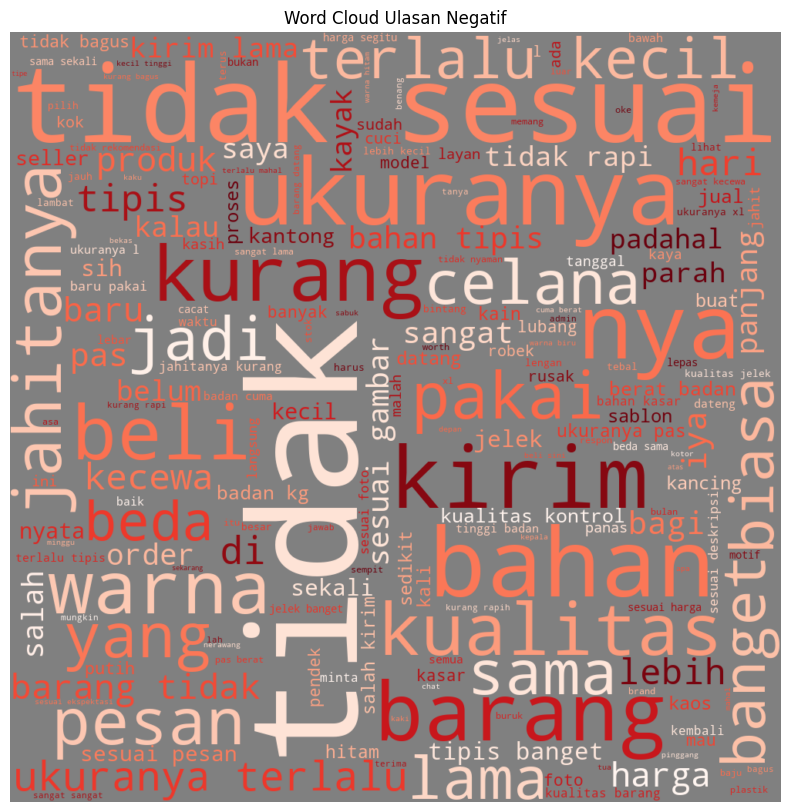

In [67]:
all_text_negatif = ' '.join(word for word in train_negatif["Ulasan"])

wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='gray').generate(all_text_negatif)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Ulasan Negatif")
plt.margins(x=0, y=0)
plt.show()

## Positif

In [68]:
train_positif = df[df["label_sentimen"] == "positive"]

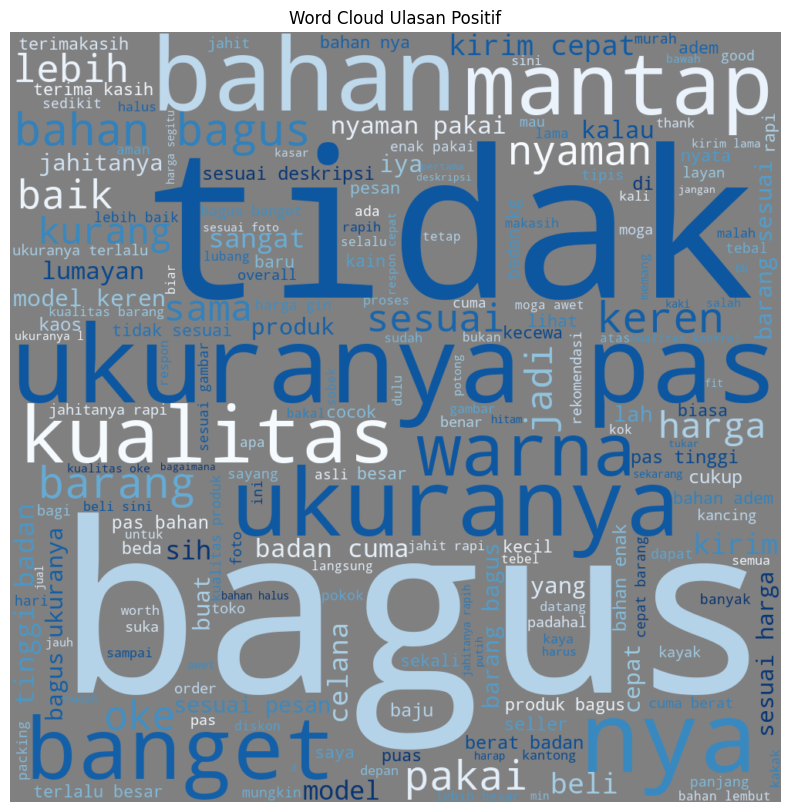

In [69]:
all_text_positif = ' '.join(word for word in train_positif["Ulasan"])

wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='gray').generate(all_text_positif)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Ulasan Positif")
plt.margins(x=0, y=0)
plt.show()

## Netral

In [70]:
train_netral = df[df["label_sentimen"] == "neutral"]

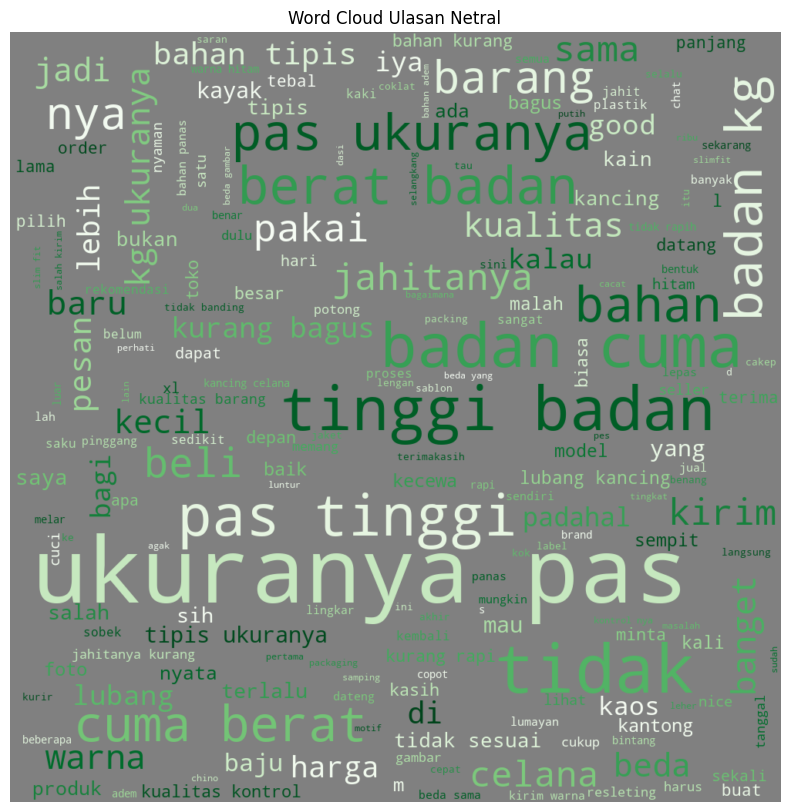

In [71]:
all_text_netral = ' '.join(word for word in train_netral["Ulasan"])

wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='gray').generate(all_text_netral)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Ulasan Netral")
plt.margins(x=0, y=0)
plt.show()